<a href="https://colab.research.google.com/github/jmorala/TFMDS/blob/main/cuadernos/01_exploracion_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [1]:
# Reemplaza 'tu_usuario' con tu nombre de usuario de GitHub
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
!git clone https://github.com/jmorala/TFMDS.git

Cloning into 'TFMDS'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 4.07 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [8]:
import os

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    os.chdir('TFMDS')
else:
    # En VS Code local, nos movemos al directorio raíz del proyecto
    # Usa raw string para evitar errores de escape en rutas Windows
    current_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(current_dir)

# OPCIONAL: Para verificar que estás en la ruta correcta y ver las carpetas
print("Directorio de trabajo actual:", os.getcwd())
# print("Contenido del directorio:")
# !ls -l

Directorio de trabajo actual: C:\Users\jmora\Documents\TFMDS


# Revisar datos

In [13]:
import pandas as pd

# Define la ruta relativa de tu archivo CSV (ajusta el nombre del archivo)
RUTA_DATOS = 'datos/Ventas.csv'

# Carga el archivo en un DataFrame de Pandas
df = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'],
    date_format='%Y%m%d')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras 5 filas del DataFrame:")
print(df.head())

print("\nInformación de las columnas y tipos de datos:")
df.info()

Primeras 5 filas del DataFrame:
   producto idSecuencia  udsVenta
0         1  2022-11-05        40
1         1  2022-11-06         0
2         1  2022-11-07        12
3         1  2022-11-08        28
4         1  2022-11-09        14

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654408 entries, 0 to 654407
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     654408 non-null  int64         
 1   idSecuencia  654408 non-null  datetime64[ns]
 2   udsVenta     654408 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 15.0 MB


In [14]:
prod_vc = df.producto.value_counts ()
print(prod_vc)
print(f'lecturas diferentes: {prod_vc.nunique()}')

producto
1       732
2       732
3       732
4       732
5       732
       ... 
996     732
997     732
998     732
999     732
1000    732
Name: count, Length: 894, dtype: int64
lecturas diferentes: 1


El número de productos es 894 y tienen 732 lecturas cada uno, no hay nulos en los datos

# Análisis Descriptivo de Ventas

Realizaremos un análisis descriptivo completo del archivo Ventas.csv que incluirá:
1. Estadísticas generales de las ventas
2. Análisis temporal de las ventas
3. Análisis por producto
4. Visualizaciones de las tendencias

In [15]:
# 1. Estadísticas generales de udsVenta
print("Resumen estadístico de las udsVenta:")
print(df['udsVenta'].describe())

print("\nTotal de udsVenta en el período:", df['udsVenta'].sum())
print("Promedio diario de udsVenta:", df['udsVenta'].mean())
print("Mediana de udsVenta:", df['udsVenta'].median())
print("Desviación estándar de udsVenta:", df['udsVenta'].std())

Resumen estadístico de las udsVenta:
count    654408.000000
mean          1.438500
std           2.698971
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         181.000000
Name: udsVenta, dtype: float64

Total de udsVenta en el período: 941366
Promedio diario de udsVenta: 1.4385001405850784
Mediana de udsVenta: 0.0
Desviación estándar de udsVenta: 2.6989708391148843


In [17]:
# 2. Análisis temporal
# Establecer la fecha como índice para análisis temporal
df_temporal = df.copy()
df_temporal.set_index('idSecuencia', inplace=True)

# Resumen por mes
udsVenta_mensuales = df_temporal.groupby(df_temporal.index.to_period('M'))['udsVenta'].sum()
print("Resumen de udsVenta mensuales:")
print(udsVenta_mensuales)

# Encontrar el día con más y menos udsVenta
dia_max_udsVenta = df_temporal.groupby(df_temporal.index.date)['udsVenta'].sum().idxmax()
dia_min_udsVenta = df_temporal.groupby(df_temporal.index.date)['udsVenta'].sum().idxmin()

print(f"\nDía con más udsVenta: {dia_max_udsVenta}")
print(f"Día con menos udsVenta: {dia_min_udsVenta}")

Resumen de udsVenta mensuales:
idSecuencia
2022-11    42013
2022-12    49144
2023-01    46014
2023-02    39082
2023-03    41222
2023-04    33659
2023-05    37886
2023-06    40366
2023-07    45777
2023-08    41078
2023-09    37723
2023-10    39513
2023-11    39995
2023-12    38470
2024-01    39920
2024-02    33093
2024-03    32938
2024-04    33096
2024-05    33295
2024-06    37195
2024-07    42255
2024-08    39974
2024-09    34156
2024-10    38429
2024-11     5073
Freq: M, Name: udsVenta, dtype: int64

Día con más udsVenta: 2022-12-09
Día con menos udsVenta: 2022-12-25


In [19]:
# 3. Análisis por producto
# Top 10 productos más vendidos
print("Top 10 productos con más udsVenta totales:")
udsVenta_por_producto = df.groupby('producto')['udsVenta'].sum().sort_values(ascending=False)
print(udsVenta_por_producto.head(10))

# Estadísticas por producto
print("\nEstadísticas por producto:")
stats_productos = df.groupby('producto')['udsVenta'].agg(['mean', 'std', 'min', 'max'])
print("\nResumen estadístico de los 5 productos más vendidos:")
print(stats_productos.loc[udsVenta_por_producto.head().index])

Top 10 productos con más udsVenta totales:
producto
1      6415
2      5319
9      4643
78     4526
13     4430
7      4380
15     4192
391    4012
3      3825
150    3687
Name: udsVenta, dtype: int64

Estadísticas por producto:

Resumen estadístico de los 5 productos más vendidos:
              mean       std  min  max
producto                              
1         8.763661  7.919233    0   49
2         7.266393  6.530268    0   42
9         6.342896  6.266421    0   35
78        6.183060  6.123833    0   33
13        6.051913  5.414682    0   28


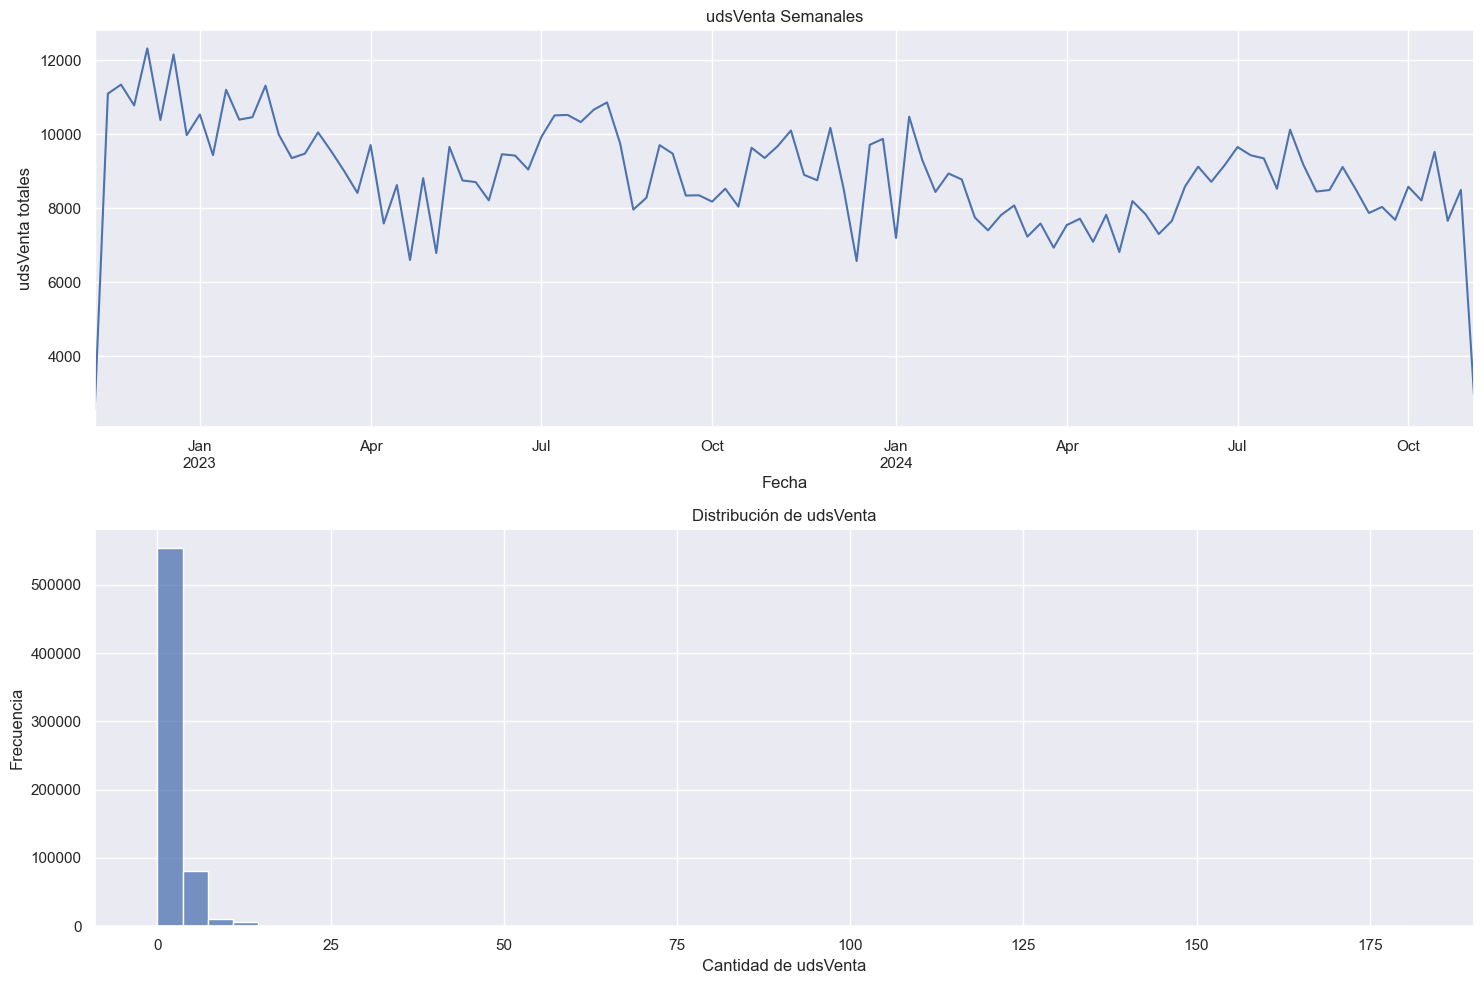

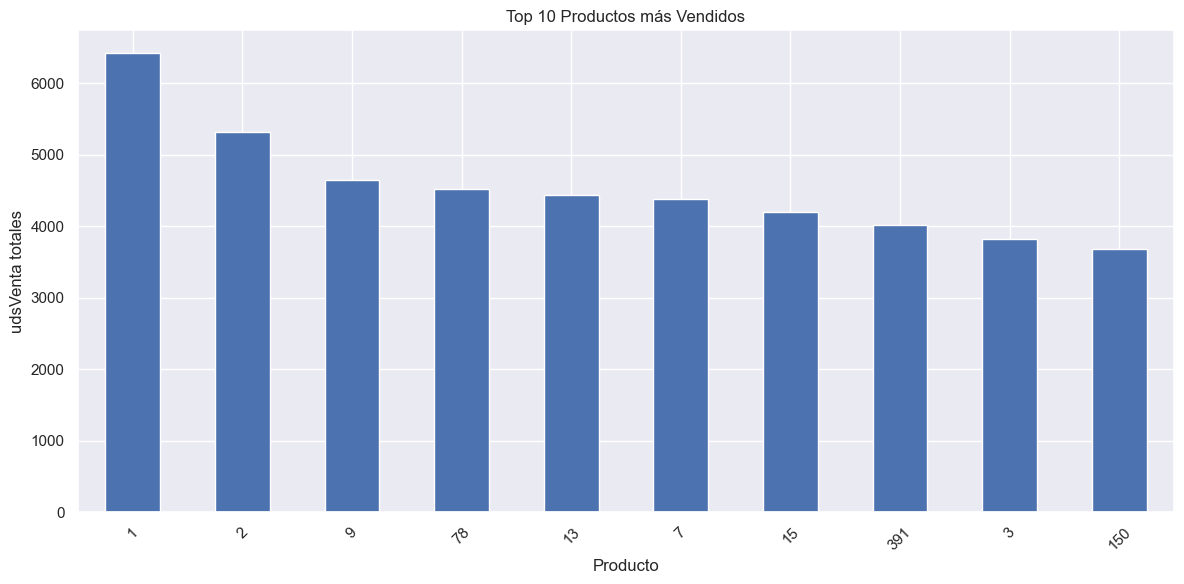

In [21]:
# 4. Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo usando seaborn (más robusto que plt.style.use('seaborn'))
sns.set_theme(style='darkgrid')

plt.figure(figsize=(15, 10))

# Gráfico de udsVenta a lo largo del tiempo
plt.subplot(2, 1, 1)
df_temporal['udsVenta'].resample('W').sum().plot(title='udsVenta Semanales')
plt.xlabel('Fecha')
plt.ylabel('udsVenta totales')

# Distribución de udsVenta
plt.subplot(2, 1, 2)
sns.histplot(data=df, x='udsVenta', bins=50, kde=False)
plt.title('Distribución de udsVenta')
plt.xlabel('Cantidad de udsVenta')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Gráfico de los 10 productos más vendidos
plt.figure(figsize=(12, 6))
udsVenta_por_producto.head(10).plot(kind='bar')
plt.title('Top 10 Productos más Vendidos')
plt.xlabel('Producto')
plt.ylabel('udsVenta totales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()